In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [161]:
# setting plot options
plt.rcParams["figure.figsize"] = (12, 8)
default_plot_colour = "#00bfbf"

In [4]:
# loading the datd
data = pd.read_csv("../dataset/fake_news_data.csv")

In [5]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of each class - Fake or Factual')

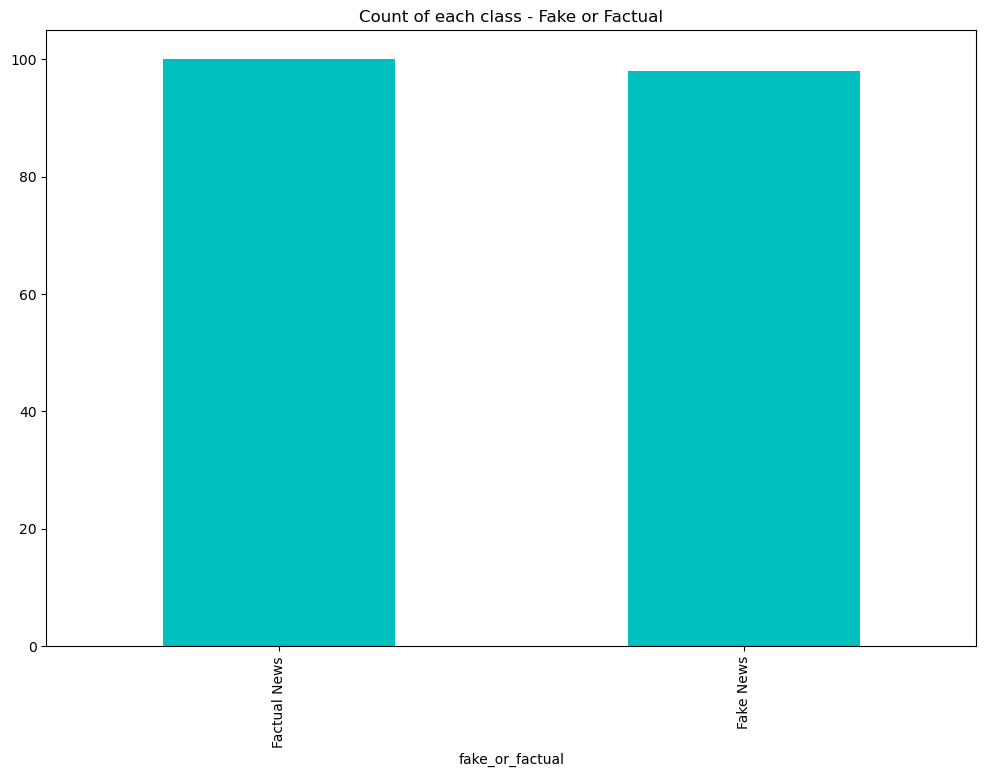

In [7]:
# checking to be sure there's an appropriate number of rows in each gorup, of:
# - fake news
# - factual news
# taking the fake_or_factual column

data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title('Count of each class - Fake or Factual')

## Data Exploration (POS and NER)

### POS Tagging - Part of Speech tagging

In [9]:
nlp = spacy.load('en_core_web_sm')

In [10]:
# splitting the fake and factual news column entries
# so as to check the pos of each different entry

In [11]:
# statrting with columns that contain "Fake News"
fake_news = data[data['fake_or_factual'] == 'Fake News']

In [12]:
# then the factual news
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [13]:
# creating two separate spacy documents for the two different classes

In [14]:
# nlp.pipe is used because what is being worked on is a dataframe
# then storing it in a list

# first, the fake news text dataset
fake_spacydocs = list(nlp.pipe(fake_news['text']))

# second, the factual news text dataset
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [15]:
# creating a function to extract the tags for each of the documents in the data, foor each of the rows in the dataframe.
# returns text, ent type and pos tags for each item in the documents.
# ent-type for named entity recognition
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [16]:
# now, tagging the fake_news dataset
# faketagsdf - fake_news_tags_dataframe
# columns - column names to be used
fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

In [17]:
# to iterate through each of the document or rows in the dataset
# and pull out the relevant tags
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    # convert the tags into a dataframe
    tags = pd.DataFrame(tags)
    # specify the column names; used here is the already defined column names
    tags.columns = columns
    # append the tags to the fake_tagsdf
    fake_tagsdf.append(tags)

In [18]:
# assign the tags back to fake_tags_df
fake_tagsdf = pd.concat(fake_tagsdf)

In [19]:
# now, tagging the factual_news dataset
# facttagsdf - factual_news_tags_dataframe
# columns - column names to be used
fact_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

# to iterate through each of the document or rows in the dataset
# and pull out the relevant tags
for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    # convert the tags into a dataframe
    tags = pd.DataFrame(tags)
    # specify the column names; used here is the already defined column names
    tags.columns = columns
    # append the tags to the fake_tagsdf
    fact_tagsdf.append(tags)

In [20]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [21]:
fact_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [22]:
# taking token frequency count for fake news dataset
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

# result shown below is essentially most frequently occuring tokens
# with their associated pos-tags and the number of times the token occurs within the dataset

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [23]:
# taking token frequency count for factual news dataset
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

# result shown is essentially most frequently occuring tokens
# with their associated pos-tags and the number of times the token occurs within the dataset

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [24]:
# checking the frequencies of individual pos_tags
# i.e. how many nouns occur? how many adjectives occur?

# first, from the fake news dataset
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [25]:
# checking the frequencies of individual pos_tags
# i.e. how many nouns occur? how many adjectives occur?

# second, from the factual news dataset
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [26]:
# since the results above are similar; nouns, verbs and proper nouns being the most frequent in both datasets
# now, to check if the specific nouns being used are also similar or do they vary a lot between the different datasets?

# first, the fake_news dataset
# display the top 15 results

pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [27]:
# second, the factual_news dataset
# display the top 15 results

pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


In [28]:
# from the results above, the words which are NOUNS that are frequent in both datasets are not necessarily the same.
# and for the words that are the same in the different datasets, their 'rankings' differ
# e.g 'government' ranks in different frequency positions in both datasets.

In [29]:
# now, to check if the specific verbs being used are also similar or do they vary a lot between the different datasets?

# first, the fake_news dataset
# display the top 15 results

pos_counts_fake[pos_counts_fake.pos_tag == 'VERB'][:15]

,token,pos_tag,counts
6763,s,VERB,147
6774,said,VERB,144
4703,have,VERB,76
5171,know,VERB,54
7534,told,VERB,49
5394,made,VERB,45
4645,had,VERB,43
4565,going,VERB,40
4562,go,VERB,40
6797,say,VERB,34


In [30]:
# second, the factual_news dataset
# display the top 15 results

pos_counts_fact[pos_counts_fact.pos_tag == 'VERB'][:15]

,token,pos_tag,counts
5567,said,VERB,451
6210,told,VERB,55
3841,have,VERB,43
6649,’s,VERB,35
4021,including,VERB,33
4410,make,VERB,31
4395,made,VERB,29
6072,take,VERB,28
3168,do,VERB,25
5582,saying,VERB,24


In [31]:
# now, to check if the specific prepositions being used are also similar or do they vary a lot between the different datasets?

# first, the fake_news dataset
# display the top 15 results

pos_counts_fake[pos_counts_fake.pos_tag == 'PROPN'][:15]

,token,pos_tag,counts
2244,Trump,PROPN,296
697,Clinton,PROPN,119
845,Donald,PROPN,75
7350,t,PROPN,74
1655,Obama,PROPN,69
1795,President,PROPN,68
1103,Hillary,PROPN,64
1481,McCain,PROPN,53
414,America,PROPN,49
2133,Syria,PROPN,42


In [32]:
# second, the factual_news dataset
# display the top 15 results

pos_counts_fact[pos_counts_fact.pos_tag == 'PROPN'][:15]

,token,pos_tag,counts
1740,Trump,PROPN,229
1759,U.S.,PROPN,177
1472,Reuters,PROPN,131
1415,President,PROPN,89
907,House,PROPN,71
1777,United,PROPN,69
1319,Obama,PROPN,56
1637,States,PROPN,56
658,Donald,PROPN,50
1838,White,PROPN,48


In [33]:
# now, to check if the specific adjectives being used are also similar or do they vary a lot between the different datasets?

# first, the fake_news dataset
# display the top 15 results

pos_counts_fake[pos_counts_fake.pos_tag == 'ADJ'][:15]

,token,pos_tag,counts
5585,more,ADJ,52
5852,other,ADJ,49
5439,many,ADJ,43
31,-,ADJ,36
6121,political,ADJ,34
1902,Republican,ADJ,32
4434,former,ADJ,31
4299,federal,ADJ,29
415,American,ADJ,28
6780,same,ADJ,27


In [34]:
# second, the factual_news dataset
# display the top 15 results

pos_counts_fact[pos_counts_fact.pos_tag == 'ADJ'][:15]

,token,pos_tag,counts
3631,former,ADJ,50
4796,other,ADJ,49
4560,more,ADJ,44
4504,military,ADJ,43
5005,political,ADJ,43
4248,last,ADJ,38
5068,presidential,ADJ,34
4646,new,ADJ,33
1462,Republican,ADJ,30
3568,first,ADJ,28


### Named Entities between the two groups 

In [36]:
# this (Named Entities) must be done before any preprocessing and cleaning of the data
# named entities have already been pulled out so now we work on what has 
# been pulled out (from POS Tagging) rather than repeating the same process

In [37]:
# top entities in the fake news dataset
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [38]:
# top named entities in the factual news dataset
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [39]:
# a plot of the named entities that have been pulled out
# can be used in presentations
ner_palette = {
    'ORG': sns.color_palette('Set2').as_hex()[0],
    'GPE': sns.color_palette('Set2').as_hex()[1],
    'NORP': sns.color_palette('Set2').as_hex()[2],
    'PERSON': sns.color_palette('Set2').as_hex()[3],
    'DATE': sns.color_palette('Set2').as_hex()[4],
    'CARDINAL': sns.color_palette('Set2').as_hex()[5],
    'PERCENT': sns.color_palette('Set2').as_hex()[6],
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

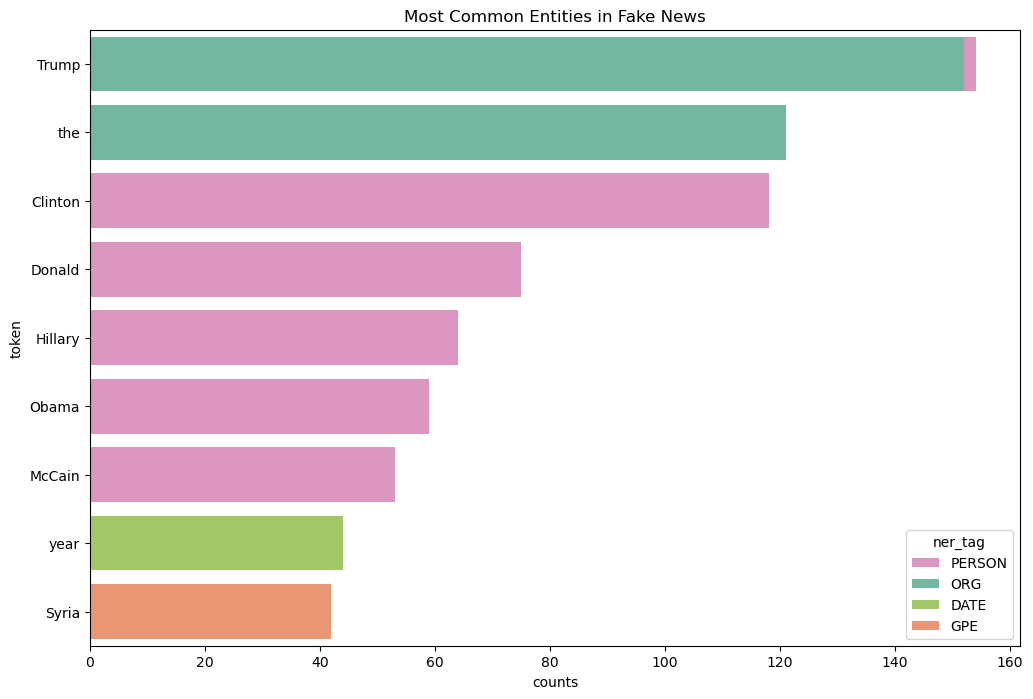

In [78]:
# plot for fake news dataset - the top named entites
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[:10], # dataset to be used
    orient = 'h', # plot should be horizontal
    dodge = False # get the bars in right format
).set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

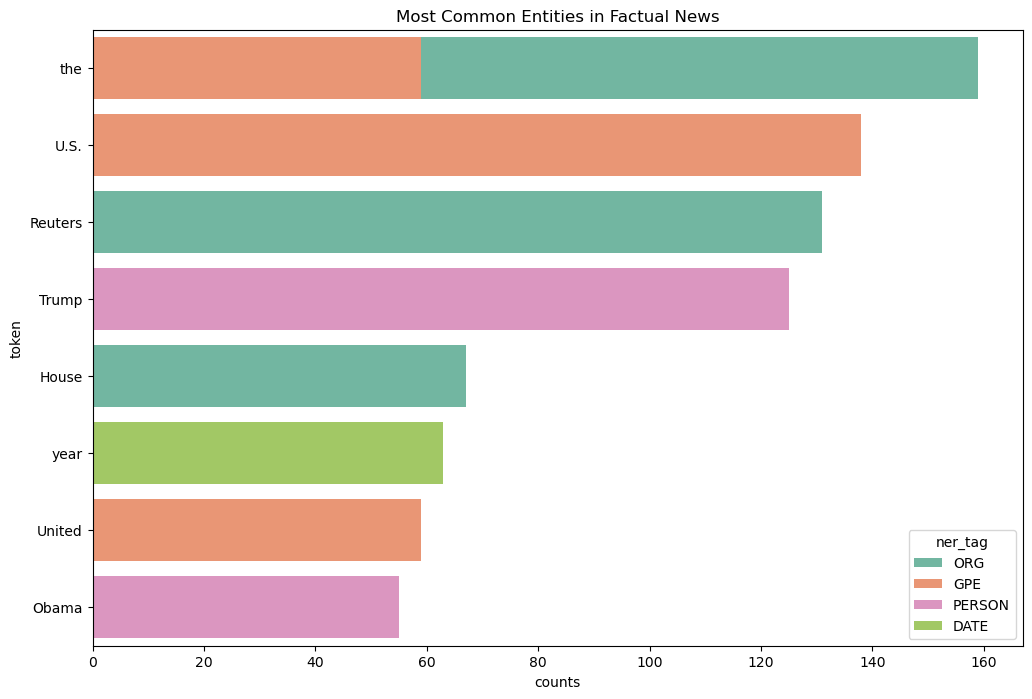

In [80]:
# plot for factual news dataset - the top named entities
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[:10], # dataset to be used
    orient = 'h', # plot should be horizontal
    dodge = False # get the bars in right format
).set(title='Most Common Entities in Factual News')

In [ ]:
# the takeaway from here (the plots) is:
# more names might be used in fake news
# while the use of names in less in factual news
# places and organizations are more common in factual news.

## Text Preprocessing

In [95]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


In [91]:
# cleaning up only the text column

In [93]:
# removing the hyphen
data['text_clean'] = data.apply(lambda x: re.sub(r'^[^-]*-\s', '', x['text']), axis=1)
# essentially, this logic is saying:
# remove everything before the hyphen and the hyphen
# replace with blank - ''
# remove it from the 'text' column
# run over the rows in the 'text' column

In [97]:
# converting the text to lowercase
data['text_clean'] = data['text_clean'].str.lower()

In [99]:
# removing punctuations
data['text_clean'] = data.apply(lambda x: re.sub(r'([^\w\s])', '', x['text_clean']), axis=1)

In [103]:
# removing stopwords

# defining the stopwords in the english language
# i.e. what are the stopwords, even?
en_stopwords = stopwords.words('english')

In [105]:
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [109]:
# now to remove the stopwords
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [111]:
data.head() # stopwords have been removed

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said monday ru...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


In [113]:
# tokenizing the text

# the logic will go through each of the rows in the dataset,
# take the text from 'text_clean',
# and convert it into word tokens
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [115]:
# lemmatizing
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [117]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [119]:
# what are the most common n-grams occuring here?

# creating a clean list of tokens
tokens_clean = sum(data['text_clean'], [])

In [153]:
# creating unigrams
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams[:10])

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


C:\Users\USEER\AppData\Local\Temp\ipykernel_12396\224466534.py:4: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

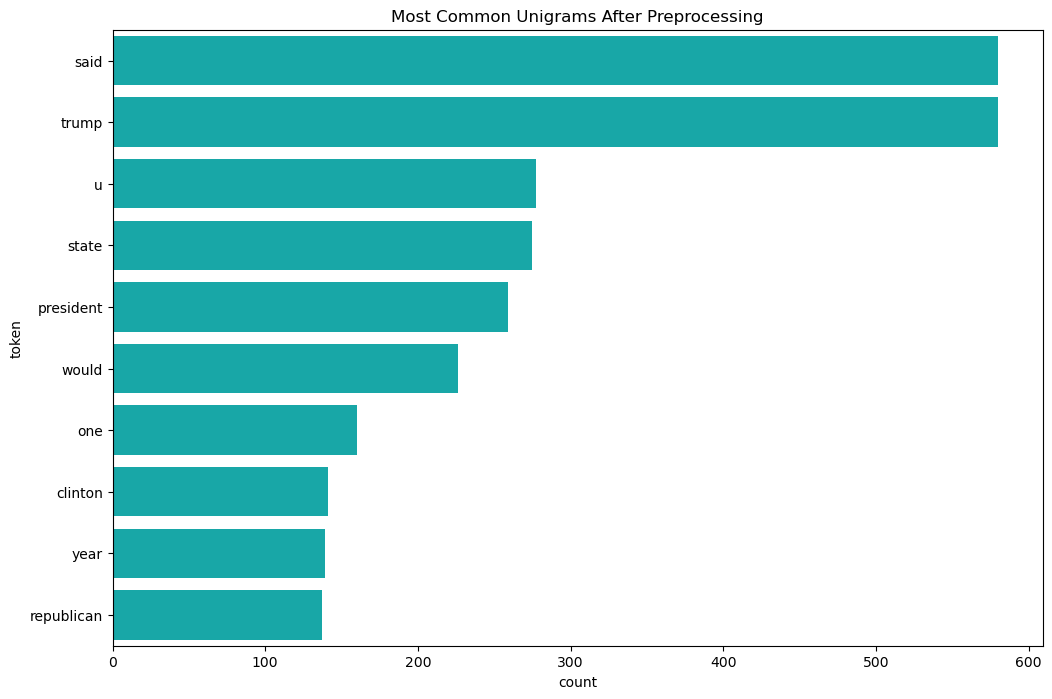

In [163]:
# plot
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])

sns.barplot(
    x='count',
    y='token',
    data=unigrams,
    orient='h',
    palette=[default_plot_colour],
    hue='token', legend=False
).set(title='Most Common Unigrams After Preprocessing')

In [167]:
# creating bigrams
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams[:10])

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


C:\Users\USEER\AppData\Local\Temp\ipykernel_12396\3037340206.py:4: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


[Text(0.5, 1.0, 'Most Common Bigrams After Preprocessing')]

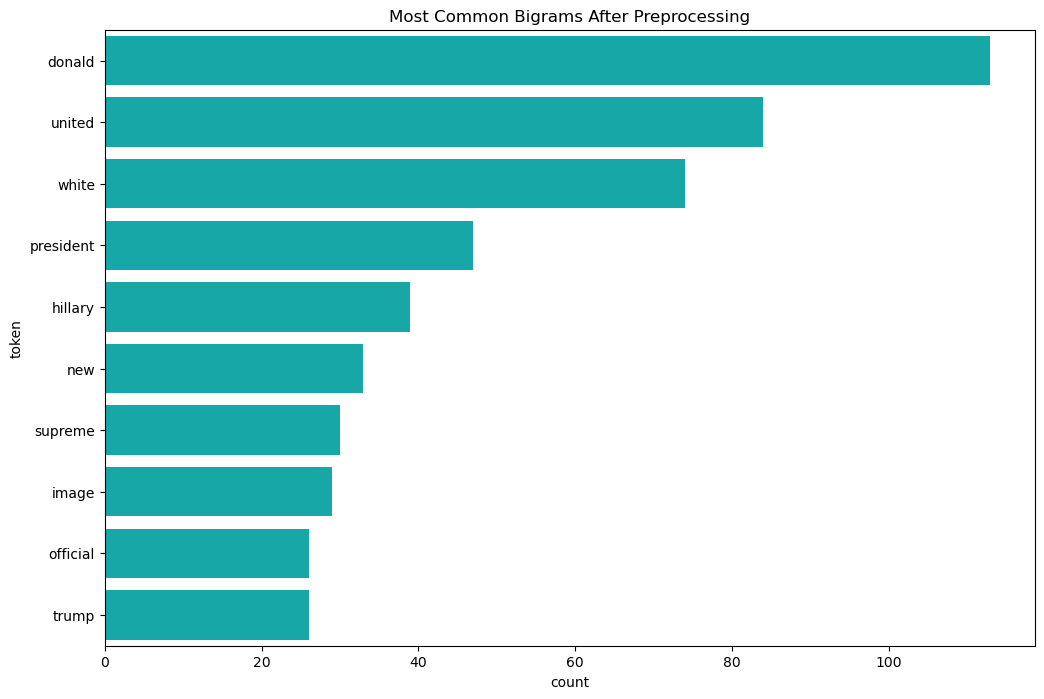

In [169]:
# plot
bigrams['token'] = bigrams['index'].apply(lambda x: x[0])

sns.barplot(
    x='count',
    y='token',
    data=bigrams,
    orient='h',
    palette=[default_plot_colour],
    hue='token', legend=False
).set(title='Most Common Bigrams After Preprocessing')

In [171]:
# creating trigrams
trigrams = (pd.Series(nltk.ngrams(tokens_clean, 3)).value_counts()).reset_index()[:10]
print(trigrams[:10])

                           index  count
0     (president, donald, trump)     46
1     (president, barack, obama)     14
2              (new, york, time)     11
3         (u, president, donald)     10
4       (white, house, official)     10
5           (food, stamp, fraud)     10
6         (fbi, director, james)      8
7       (director, james, comey)      8
8        (high, school, student)      7
9  (national, security, adviser)      7


C:\Users\USEER\AppData\Local\Temp\ipykernel_12396\3056695877.py:4: UserWarning: 
The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


[Text(0.5, 1.0, 'Most Common Trigrams After Preprocessing')]

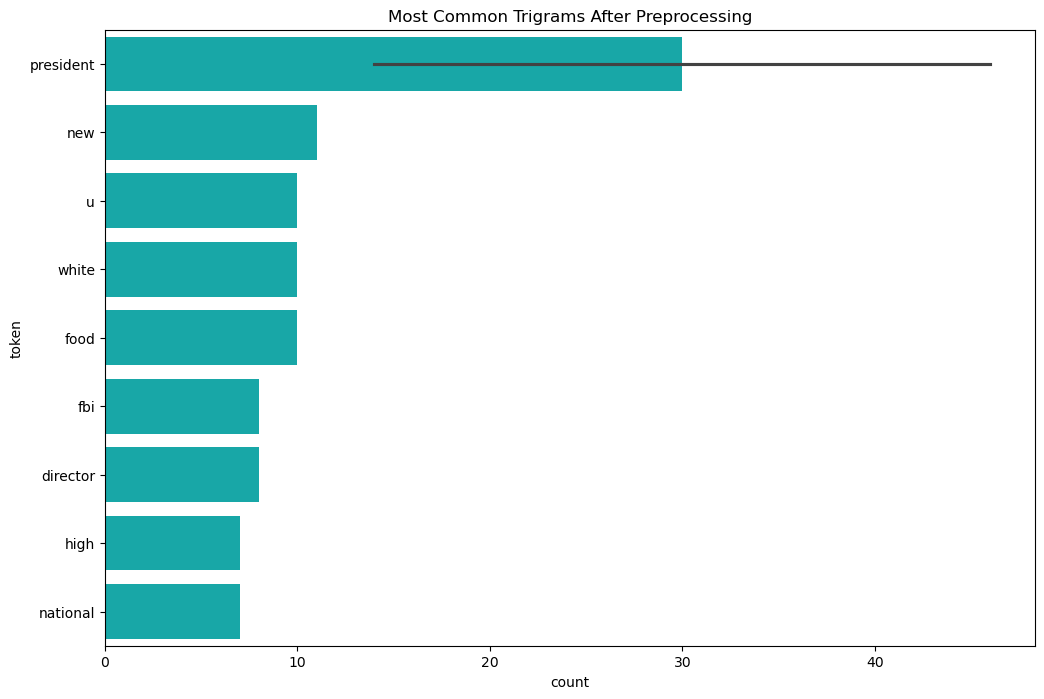

In [173]:
# plot
trigrams['token'] = trigrams['index'].apply(lambda x: x[0])

sns.barplot(
    x='count',
    y='token',
    data=trigrams,
    orient='h',
    palette=[default_plot_colour],
    hue='token', legend=False
).set(title='Most Common Trigrams After Preprocessing')

## Sentiment Analysis

In [176]:
vader_sentiment = SentimentIntensityAnalyzer()

In [178]:
# creating the score column using the raw data to calculate
# i.e. the 'text' column and not the cleaned/preprocessed data - 'text_clean' column
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [180]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [182]:
# classifying the scores into positive, negative and neutral sentiments
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

In [184]:
# creating vader sentiment label column
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [186]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [188]:
# does sentiment differ between the different news groups?

# creating a bar chart of the different sentiment labels in each of the news types data

<Axes: xlabel='vader_sentiment_label'>

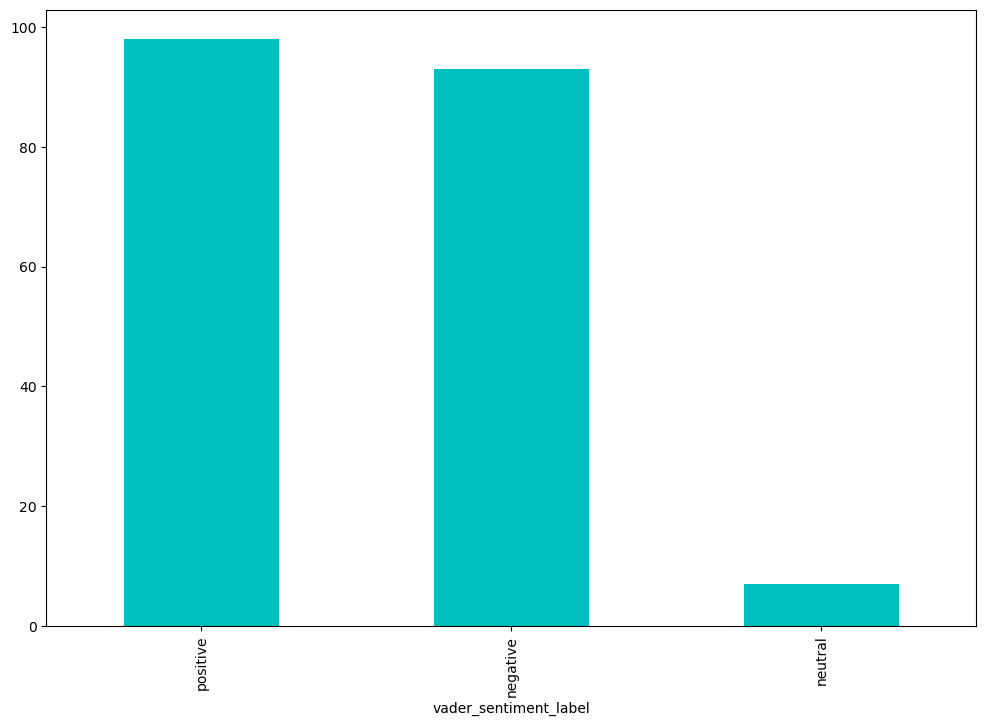

In [190]:
# first, overall, how many pos, neg or neutral are there in the entire dataset?
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

C:\Users\USEER\AppData\Local\Temp\ipykernel_12396\230012654.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

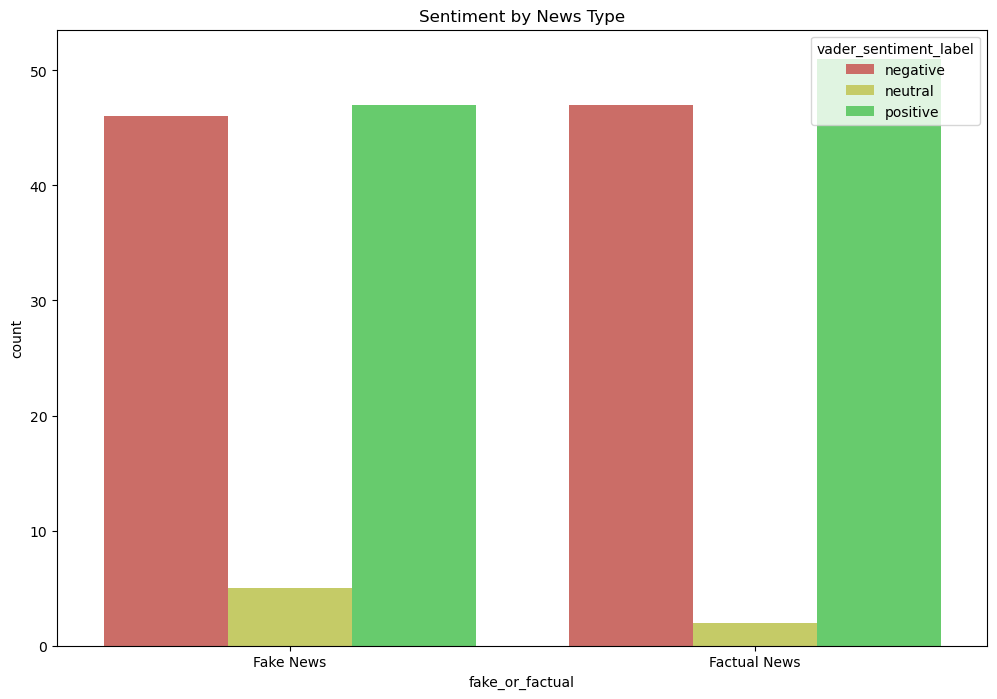

In [194]:
# variations in the two types of news
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette('hls'),
    data = data
).set(title='Sentiment by News Type')

## Topic Modelling

In [197]:
# using bag of words vectorization and latent dirichlet allocation (lda)
# first, vectorization in order to enable feeding into the LDA algorithm
fake_news_text = data[data['fake_or_factual'] == 'Fake News']['text_clean'].reset_index(drop=True)

In [199]:
# creating dictionary
dictionary_fake = corpora.Dictionary(fake_news_text)

In [209]:
# creating the bag of words
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [211]:
# generating coherence scores to determine the optimum number of topics
coherence_values = []
model_list = []

# minimum and maximum topics to be tested
min_topics = 2
max_topics = 11

# to run over each of the iterations of this model
for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics = num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

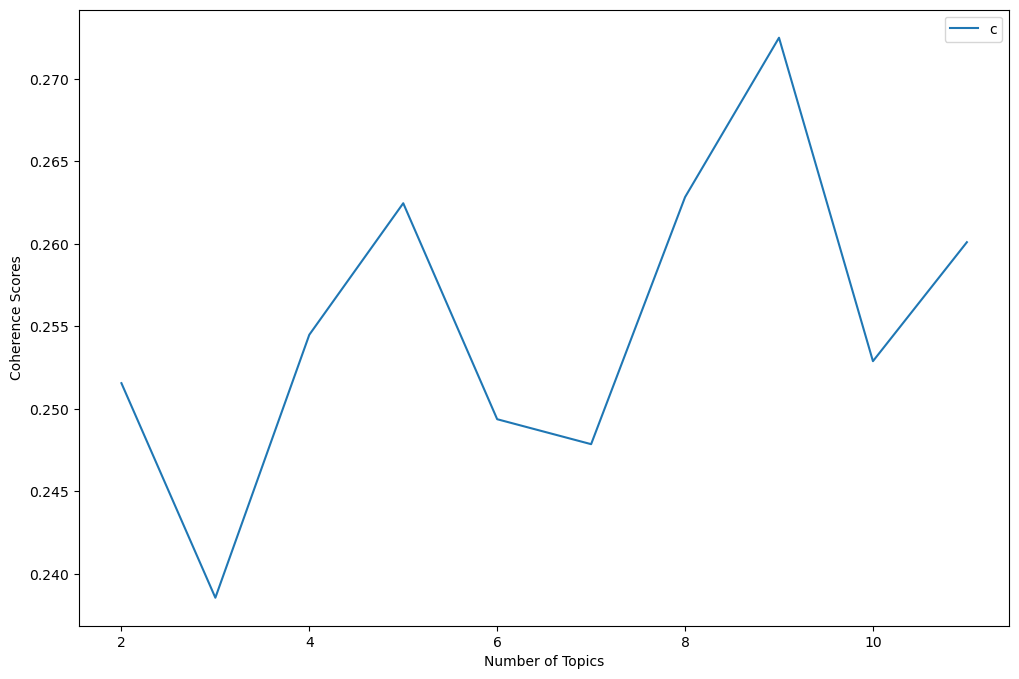

In [217]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [219]:
# working on the final lda model that uses 7 topics
num_topics_lda = 7
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_lda)

In [221]:
# printing out the words that occur with each topic
lda_model.print_topics(num_topics_lda, num_words=10)

[(0,
  '0.010*"trump" + 0.004*"u" + 0.004*"clinton" + 0.004*"said" + 0.004*"would" + 0.004*"woman" + 0.004*"one" + 0.003*"news" + 0.003*"president" + 0.003*"time"'),
 (1,
  '0.009*"trump" + 0.005*"president" + 0.005*"state" + 0.004*"said" + 0.003*"republican" + 0.003*"one" + 0.003*"school" + 0.003*"clinton" + 0.003*"would" + 0.003*"go"'),
 (2,
  '0.009*"trump" + 0.004*"said" + 0.004*"one" + 0.004*"woman" + 0.004*"state" + 0.003*"republican" + 0.003*"president" + 0.003*"clinton" + 0.003*"donald" + 0.003*"go"'),
 (3,
  '0.012*"trump" + 0.006*"president" + 0.005*"said" + 0.004*"state" + 0.004*"republican" + 0.004*"u" + 0.004*"people" + 0.004*"clinton" + 0.004*"one" + 0.004*"would"'),
 (4,
  '0.006*"trump" + 0.004*"president" + 0.003*"time" + 0.003*"said" + 0.003*"obama" + 0.003*"u" + 0.003*"would" + 0.002*"clinton" + 0.002*"know" + 0.002*"also"'),
 (5,
  '0.010*"trump" + 0.005*"state" + 0.005*"u" + 0.004*"clinton" + 0.004*"email" + 0.004*"said" + 0.003*"time" + 0.003*"obama" + 0.003*"dona

In [227]:
# using tf-idf vectorization and latent semantic analysis (lsa)

# function to create tfidf corpus
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus = doc_term_matrix, normalize = True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [253]:
# a function to get the coherence scores 
# to find the most optimal value for the number of topics
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics = num_topics_i, id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts = text, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'), loc='best')
    plt.show()

In [255]:
# creating tfidf representation of text
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

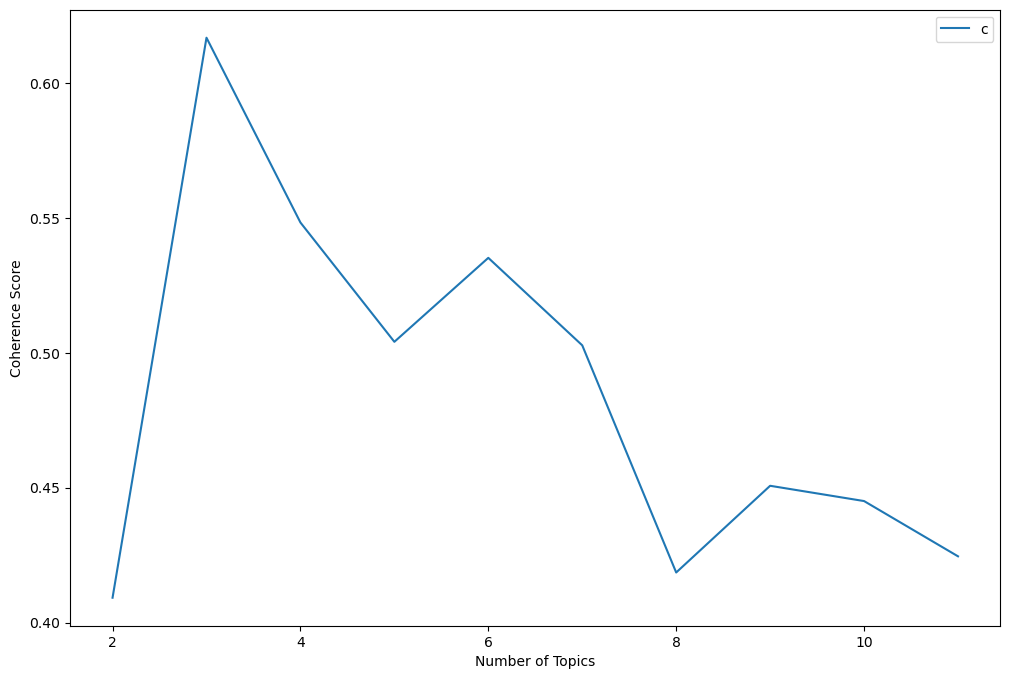

In [257]:
# getting coherence score
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [259]:
# final model
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=3)

In [261]:
lsa_model.print_topics()

[(0,
  '-0.190*"trump" + -0.136*"clinton" + -0.095*"hillary" + -0.094*"obama" + -0.089*"president" + -0.087*"woman" + -0.078*"republican" + -0.077*"party" + -0.077*"flynn" + -0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"tune" + -0.142*"animal" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '0.623*"flynn" + 0.182*"immunity" + 0.122*"nana" + 0.116*"mr" + 0.110*"30" + 0.108*"march" + 0.102*"russian" + 0.100*"source" + -0.095*"school" + 0.092*"adviser"')]

## Creating (Custom) Classification Model

In [265]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [269]:
X = [','.join(map(str, k)) for k in data['text_clean']]

In [271]:
Y = data['fake_or_factual']

In [273]:
# vectorization - using the Bag of words for vectorization
countvec = CountVectorizer()

In [275]:
countvec_fit = countvec.fit_transform(X)

In [277]:
# creating the bag of words and storing ti as a dataframe
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [281]:
# splitting and training using the data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size = 0.3)

In [283]:
# using Logistic Regression
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [285]:
y_pred_lr = lr.predict(X_test)

In [287]:
accuracy_score(y_pred_lr, y_test)

0.8833333333333333

In [289]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.84      0.93      0.89        29
   Fake News       0.93      0.84      0.88        31

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



In [291]:
# using Support Vector Machine(SVM)

In [293]:
svm = SGDClassifier().fit(X_train, y_train)

In [295]:
y_pred_svm = svm.predict(X_test)

In [297]:
accuracy_score(y_pred_svm, y_test)

0.8333333333333334

In [299]:
print(classification_report(y_pred_svm, y_test))

              precision    recall  f1-score   support

Factual News       0.93      0.77      0.84        35
   Fake News       0.74      0.92      0.82        25

    accuracy                           0.83        60
   macro avg       0.84      0.85      0.83        60
weighted avg       0.85      0.83      0.83        60



In [301]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.77      0.93      0.84        29
   Fake News       0.92      0.74      0.82        31

    accuracy                           0.83        60
   macro avg       0.85      0.84      0.83        60
weighted avg       0.85      0.83      0.83        60

